## Regression for Diabetes Dataset

Prediction of a quantitative measure of the disease progression one year after baseline.

### 

> for TeX typesetting plese use [Markdown All in One](https://marketplace.visualstudio.com/items?itemName=yzhang.markdown-all-in-one) extension. 

In [80]:
import numpy as np 
import pandas as pd

# plotting
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

# baseline linear model
from sklearn.linear_model import LinearRegression

# neural network
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 

# gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# utils
from sklearn.datasets import load_diabetes
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sns.set_theme(style="white")
sns.set(font_scale=1.5, rc={'text.usetex' : True})

In [134]:
def make_nn_regressor(input_dim):
    """ 
    Neural network based regressor,
    Args:
        input_dim: (int) the size of the input vectors
    """
    model = Sequential()
    layers = [
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(1, activation='linear'),
    ]
    opt = Adam(learning_rate=0.0005)

    for l in layers:
        model.add(l)
    
    # compile the keras model
    model.compile(
        loss='mse', 
        optimizer=opt, 
        metrics=['mse', 'cosine_similarity'])

    return model

In [135]:
def plot_model_evaluation(model, X, Y):
    """Plot model performance."""
    Y_pred = model.predict(X)
    # metrics 
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    mae = mean_absolute_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    # plot
    fig, ax = plt.subplots(figsize=(6,6)) 
    sns.lineplot(x=np.arange(-2, 2, 0.1), y=np.arange(-2, 2, 0.1))
    sns.scatterplot(x=Y.flatten(), y=Y_pred.flatten())
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.title(f'R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}')
    plt.show()

### Data Survey

In [28]:
# load data set for regression 
dataset = load_diabetes(as_frame=True)
# predictors 
data = dataset['data']
# target
target = dataset['target']
data['target'] = target

In [4]:
data.describe()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


In [5]:
target.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

In [6]:
fig = px.scatter_3d(
                    data, 
                    x='age', 
                    y='bmi', 
                    z='s2', 
                    color='target'
                    )
fig.show()

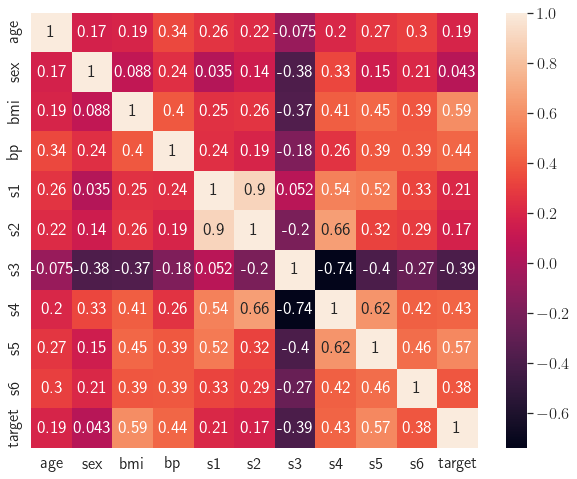

In [7]:
f, ax = plt.subplots(1, figsize=(10,8))
sns.heatmap(data.corr(), annot=True, ax=ax)
plt.show()

### Training and Test data sets assembly

In [107]:
# predictor target as numpy array 
X, Y = data.values[:, :10], target.values
n, p = X.shape
# scale predictors and target 
scaler_y = StandardScaler()
scaler_x = StandardScaler()

scaler_y.fit(Y.reshape(-1, 1))
scaler_x.fit(X)

Ysc = scaler_y.transform(Y.reshape(-1, 1))
Xsc = scaler_x.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(Xsc, Ysc, test_size=0.2, random_state=25)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'Target Min: {np.min(Ysc):.2f}, Max: {np.max(Ysc):.2f}, Std: {np.std(Ysc):.2f}, Mean: {np.mean(Ysc):.2f}')
print(f'Predictors Min: {np.min(Xsc):.2f}, Max: {np.max(Xsc):.2f}, Std: {np.std(Xsc):.2f}, Mean: {np.mean(Xsc):.2f}')

Train size: 353
Test size: 89
Target Min: -1.65, Max: 2.52, Std: 1.00, Mean: -0.00
Predictors Min: -2.90, Max: 4.18, Std: 1.00, Mean: -0.00


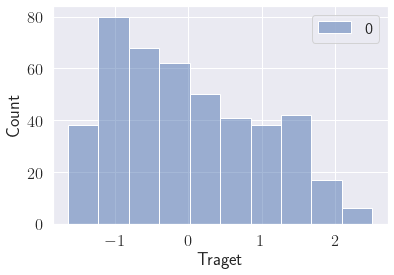

In [30]:
sns.histplot(Ysc)
plt.xlabel('Traget')
plt.show()

### Linear Model 

In [96]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)


LinearRegression()

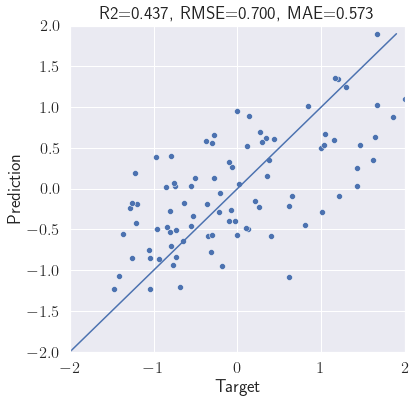

In [97]:
plot_model_evaluation(linear_model, X_test, Y_test)

### Artificial Neural Network Model

In [136]:
model = make_nn_regressor(p)

history = model.fit(X_train, Y_train,
                    epochs=1000,
                    batch_size=1,
                    validation_split=0.2,
                    verbose=0
                   )

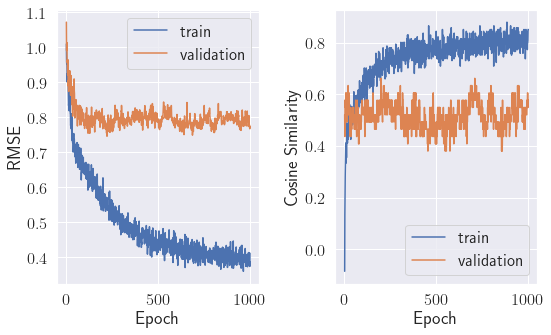

In [133]:
x = np.arange(1, len(history.history['loss']) + 1, 1)

fig, ax = plt.subplots(figsize=(8, 5)) 

plt.subplot(1,2,1)
sns.lineplot(x=x, y=np.sqrt(history.history['loss']), label='train')
sns.lineplot(x=x, y=np.sqrt(history.history['val_loss']), label='validation')
plt.ylabel('RMSE')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
sns.lineplot(x=x, y=history.history['cosine_similarity'], label='train')
sns.lineplot(x=x, y=history.history['val_cosine_similarity'], label='validation')
plt.ylabel('Cosine Similarity')
plt.xlabel('Epoch')

plt.tight_layout()

plt.show()

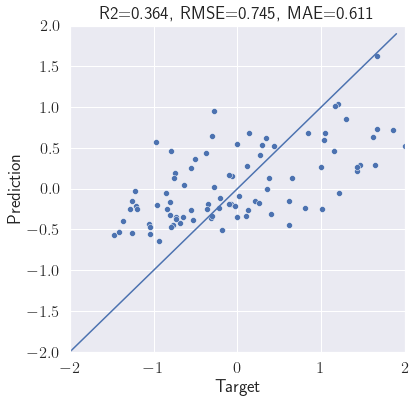

In [104]:
plot_model_evaluation(model, X_test, Y_test)

### Gaussian Processes

In [83]:
kernel = Matern(length_scale=[3] * p, nu=1.5) * ConstantKernel()

gp_model = GaussianProcessRegressor(
                                    kernel=kernel,
                                    alpha=0.0001
                                    )

gp_model.fit(X_train, Y_train)    

GaussianProcessRegressor(alpha=0.0001,
                         kernel=Matern(length_scale=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3], nu=1.5) * 1**2)

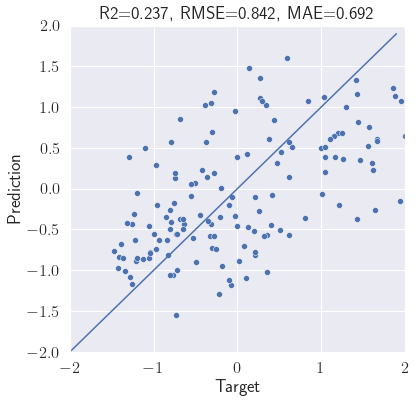

In [84]:
plot_model_evaluation(gp_model, X_test, Y_test)